In [0]:
spark

In [0]:
# Standard Libraries
from datetime import date, timedelta

# Spark
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.functions import lower, get_json_object, when, coalesce, length
from pyspark.sql.utils import AnalysisException
from pyspark.sql import SparkSession

# Análise descritiva dos dados

**Indicadores relevantes**

In [0]:
df_rest = (spark.table("workspace.default.ab_test_ref")
    .groupBy("is_target")
    .agg(
        F.count("is_target").alias("Freq"),
        (F.count("is_target") * 1.0 / F.sum(F.count("is_target")).over(Window.partitionBy(F.lit(1))) * 100).alias("Percent")
    )
    .withColumn("Percent", F.round("Percent", 2)) 
    .orderBy(F.desc("Freq"))
)

display(df_rest)

is_target Freq Percent target 445925 55.29 control 360542 44.71

In [0]:
df_user_order_counts = (spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .groupBy("customer_id_order", "is_target")
    .agg(
        F.count(F.col("order_id")).alias("num_pedidos") # Total de pedidos por grupo
    )
)

# Passo 2: Calcular as métricas descritivas por grupo

df_result_order_final = (spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .groupBy("is_target")
    .agg(
        F.count(F.col("order_id")).alias("volume_pedidos"), # Total de pedidos por grupo
        F.avg(F.col("order_total_amount")).alias("media_valor_pedido"), # Média do valor dos pedidos por grupo
        F.stddev(F.col("order_total_amount")).alias("desvio_padrao_valor_pedido"), # Desvio Padrão do valor dos pedidos
        F.sum(F.col("order_total_amount")).alias("total_valor_pedido"), # Soma do valor dos pedidos por grupo
        F.expr("percentile_approx(order_total_amount, 0.5)").alias("mediana_valor_pedido") # Mediana do valor dos pedidos por grupo
    )
    # Join para trazer a média e a mediana dos pedidos por grupo
    .join(
        df_user_order_counts.groupBy("is_target").agg(
            F.avg(F.col("num_pedidos")).alias("media_pedidos"), # Média de pedidos por grupo
            F.expr("percentile_approx(num_pedidos, 0.5)").alias("mediana_pedidos") # Mediana de pedidos por grupo
        ),
        on="is_target",
        how="inner"
    )
    # Formatação das colunas para 2 casas decimais
    .withColumn("media_pedidos", F.format_number("media_pedidos", 2))
    .withColumn("mediana_pedido", F.format_number("mediana_pedidos", 2)) 
    .withColumn("mediana_valor_pedido", F.format_number("mediana_valor_pedido", 2)) 
    .withColumn("media_valor_pedido", F.format_number("media_valor_pedido", 2))
    .withColumn("desvio_padrao_valor_pedido", F.format_number("desvio_padrao_valor_pedido", 2))
    .withColumn("total_valor_pedido", F.format_number("total_valor_pedido", 2))
    # Reordenando as colunas
    .select(
        F.col("is_target"), 
        F.col("volume_pedidos"),
        F.col("media_pedidos"),
        F.col("mediana_pedidos"),
        F.col("total_valor_pedido"),
        F.col("media_valor_pedido"),
        F.col("mediana_valor_pedido"),
        F.col("desvio_padrao_valor_pedido")
    )
)


display(df_result_order_final)

is_target volume_pedidos media_pedidos mediana_pedidos total_valor_pedido media_valor_pedido mediana_valor_pedido desvio_padrao_valor_pedido control 5983900 16.60 8 360,890,967.53 60.31 47.20 503.44 target 8353996 18.73 9 492,312,734.63 58.93 47.30 49.81

A análise descritiva dos resultados do teste A/B, desenhado para avaliar o impacto de uma estratégia de cupons na retenção de usuários, nos fornece as seguintes informações:

- Ao analisar os dados agregados, observa-se que o grupo de teste (grupo que recebeu o cupom especial) apresentou um volume de pedidos significativamente maior e uma média de pedidos superior em comparação ao grupo de controle (assim como a mediana). Isso sugere um indicativo preliminar de que os usuários no grupo de teste tendem a comprar mais ou a retornar com maior frequência, o que está alinhado com o objetivo de incentivar a recorrência de compras.

- Da mesma maneira, a soma dos valores dos pedidos do grupo de teste é substancialmente maior. Contudo, é importante notar que a média dos valores dos pedidos do grupo controle é ligeiramente superior. Porém, a mediana dos dois grupos é bem próxima. Essa distinção levanta a questão se o cupom está de fato estimulando pedidos de maior valor unitário ou se a estratégia está mais focada em volume de transações, o que será crucial para a análise de viabilidade financeira da iniciativa. 

- Para confirmar a significância estatística dessas observações e validar se as diferenças identificadas não são meramente aleatórias, o próximo passo será aprofundar a análise por meio de testes estatísticos, a fim de determinar o real impacto do cupom nessas métricas de desempenho.

- Um ponto super importante é o resultado do desvio padrão. Ele mostra que há uma grande variabilidade de valores de pedido no grupo controle. Isso sugere que o grupo control tem: uma gama muito mais ampla de valores de pedidos ou a presença de pedidos de valores muito altos (outliers) que puxam o desvio padrão para cima.


_Conceito de mediana: a mediana é uma medida de tendência central que representa o valor que divide os dados ordenados em duas metades iguais. Em outras palavras, quando os dados são organizados em ordem crescente ou decrescente, a mediana é o valor que está exatamente no meio da distribuição, de modo que 50% dos dados são menores ou iguais a ele e 50% dos dados são maiores ou iguais a ele. A principal vantagem da mediana em relação à média é que ela é robusta a outliers (valores extremos). Isso significa que valores atípicos de valor de pedido, por exemplo, tornando-a uma medida mais representativa para distribuições assimétricas_

In [0]:

# Número de pedidos únicos por usuário (sem outliers)
df_user_order_counts = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    # .filter(F.col("order_total_amount") <= 5000)  # Retirando outilers
    .dropDuplicates(["order_id"])  # Garante 1 linha por pedido
    .groupBy("customer_id_order", "is_target")
    .agg(
        F.count("order_id").alias("num_pedidos")  # Pedidos únicos por usuário
    )
)

# Métricas descritivas por grupo A/B
df_result_order_final = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    # .filter(F.col("order_total_amount") <= 5000)  
    .dropDuplicates(["order_id"])  
    .groupBy("is_target")
    .agg(
        F.count("order_id").alias("volume_pedidos"),
        F.avg("order_total_amount").alias("media_valor_pedido"),
        F.stddev("order_total_amount").alias("desvio_padrao_valor_pedido"),
        F.sum("order_total_amount").alias("total_valor_pedido"),
        F.expr("percentile_approx(order_total_amount, 0.5)").alias("mediana_valor_pedido")
    )
    # Join com a tabela de usuários para trazer média e mediana de pedidos por usuário
    .join(
        df_user_order_counts.groupBy("is_target").agg(
            F.avg("num_pedidos").alias("media_pedidos"),
            F.expr("percentile_approx(num_pedidos, 0.5)").alias("mediana_pedidos")
        ),
        on="is_target",
        how="inner"
    )
    # Formatação das colunas para 2 casas decimais
    .withColumn("media_pedidos", F.format_number("media_pedidos", 2))
    .withColumn("mediana_pedidos", F.format_number("mediana_pedidos", 2))
    .withColumn("media_valor_pedido", F.format_number("media_valor_pedido", 2))
    .withColumn("mediana_valor_pedido", F.format_number("mediana_valor_pedido", 2))
    .withColumn("desvio_padrao_valor_pedido", F.format_number("desvio_padrao_valor_pedido", 2))
    .withColumn("total_valor_pedido", F.format_number("total_valor_pedido", 2))
    .select(
        "is_target", 
        "volume_pedidos",
        "media_pedidos",
        "mediana_pedidos",
        "total_valor_pedido",
        "media_valor_pedido",
        "mediana_valor_pedido",
        "desvio_padrao_valor_pedido"
    )
)

display(df_result_order_final)


is_target volume_pedidos media_pedidos mediana_pedidos total_valor_pedido media_valor_pedido mediana_valor_pedido desvio_padrao_valor_pedido control 1010738 2.80 1.00 48,432,203.49 47.92 39.90 146.14 target 1416677 3.18 2.00 67,729,986.45 47.81 39.90 48.78

A análise descritiva do teste A/B — realizado para avaliar o impacto de uma estratégia de cupons na recorrência e engajamento de usuários — revela os seguintes insights com base nos dados filtrados (sem outliers acima de R$5.000 e com agregação correta por pedido):
- Os usuários do grupo de teste tenderam a comprar com mais frequência, o que sugere um possível efeito positivo da campanha no comportamento de recompra — um dos principais objetivos do uso de cupons.
- A soma de valores dos pedidos do grupo teste foi superior ao grupo controel, porém a media e a mediana ficam bem próximas. Ou seja, o cupom não aumentou o valor individual dos pedidos, mas sim o número de pedidos feitos por usuário. Ou seja, o impacto parece estar relacionado mais à frequência de compra do que a um aumento no ticket médio.
- Para validar se essas diferenças observadas são estatisticamente significativas será necessário aplicar testes estatísticos apropriados (como teste de Wilcoxon), a fim de confirmar o impacto real da campanha.


# Análise estatística - Parte I

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import numpy as np
from plotnine import *
import geopandas as gpd
import plotly.express as px
from scipy.stats import shapiro, mannwhitneyu

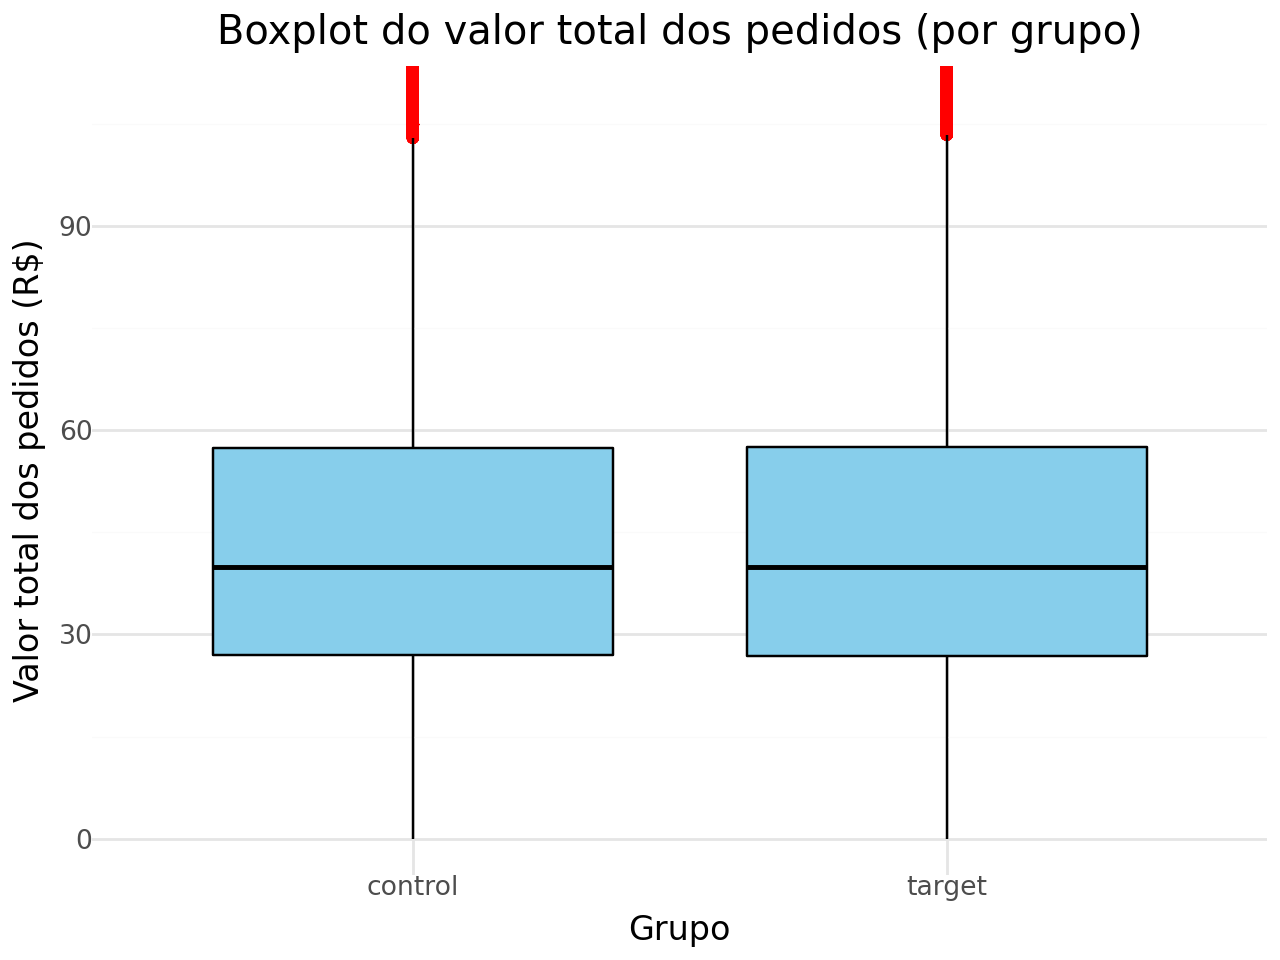

In [0]:
# Preparar os dados (remover outliers e garantir 1 linha por pedido)
df_pandas = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .dropDuplicates(["order_id"])
    .select("is_target", "order_total_amount")
    .toPandas()
)

# Limite superior (P95), para melhor vizualização gráfica
limite = np.percentile(df_pandas['order_total_amount'], 95)

# Gráfico com o mesmo estilo do ggplot2 do R (com ou sem coord_cartesian)
(
    ggplot(df_pandas, aes(x='is_target', y='order_total_amount')) +
    geom_boxplot(fill="skyblue", color="black", outlier_color="red") +
    coord_cartesian(ylim=(0, limite)) +
    labs(
        title="Boxplot do valor total dos pedidos (por grupo)",
        x="Grupo",
        y="Valor total dos pedidos (R$)"
    ) +
    theme_minimal(base_size=12)
)

Perceba, através do boxplot, que o valor total dos pedidos possuem uma distibuição muito próxima nos dois grupos.

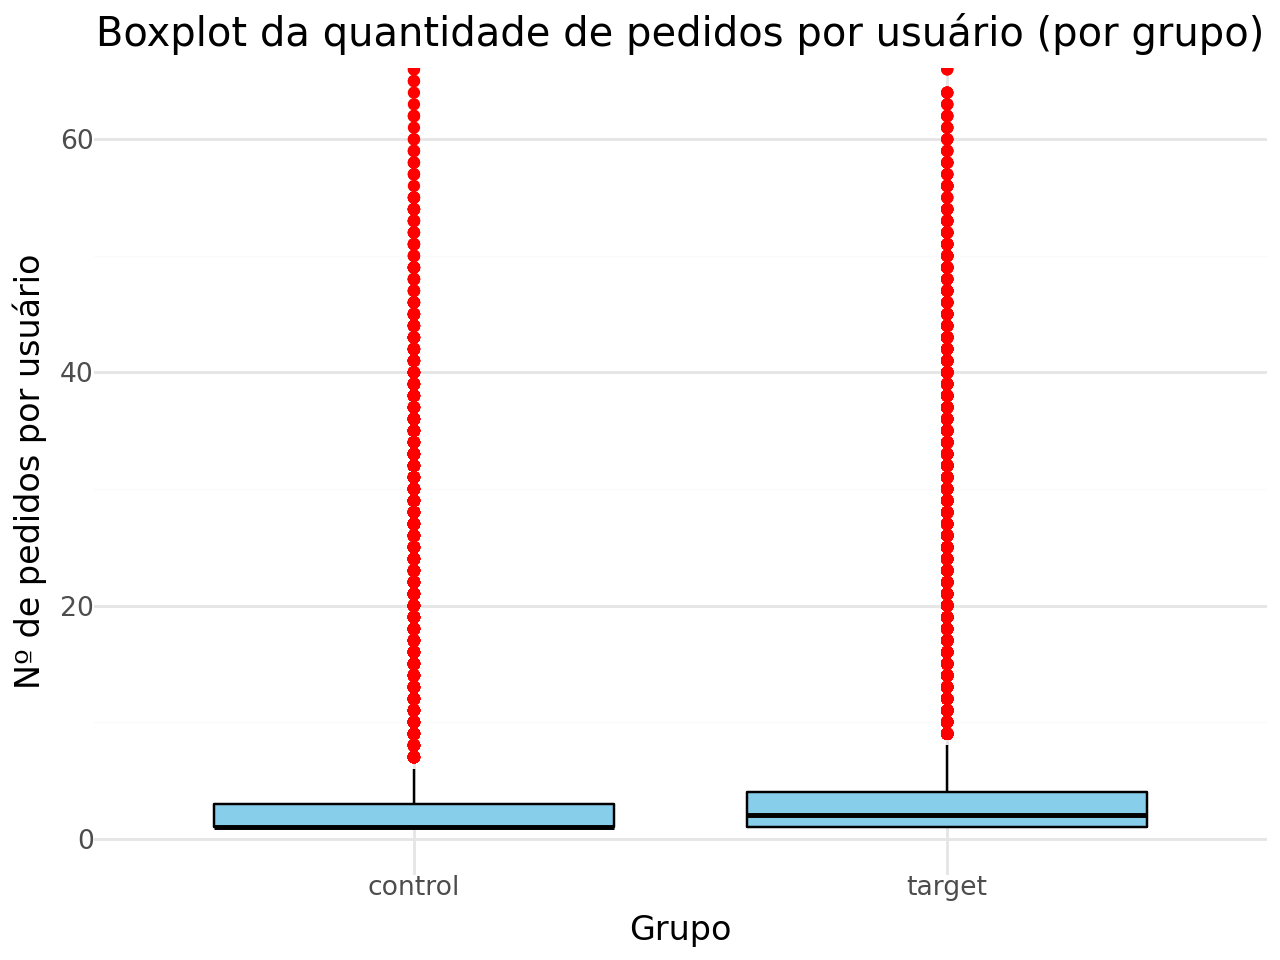

In [0]:
df_user_counts = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .dropDuplicates(["order_id"])
    .groupBy("customer_id_order", "is_target")
    .agg(F.count("order_id").alias("num_pedidos"))
).toPandas()

# Limite superior (P95), para melhor vizualização gráfica
limite = np.percentile(df_pandas['order_total_amount'], 80)

# Gráfico com o mesmo estilo do ggplot2 do R (com ou sem coord_cartesian)
(
    ggplot(df_user_counts, aes(x='is_target', y='num_pedidos')) +
    geom_boxplot(fill="skyblue", color="black", outlier_color="red") +
    coord_cartesian(ylim=(0, limite)) +
    labs(
        title="Boxplot da quantidade de pedidos por usuário (por grupo)",
        x="Grupo",
        y="Nº de pedidos por usuário"
    ) +
    theme_minimal(base_size=12)
)

A grande maioria dos usuários, tanto no grupo de controle quanto no grupo de teste, faz poucos pedidos (1, 2 ou 3, por exemplo). No entanto, ambos os grupos também têm alguns usuários que fazem um número muito maior de pedidos, chegando a cerca de 60-70 pedidos no total. Porém, No grupo de teste notamos que há usuários realizando mais pedidos que no grupo controle.

Para validar se essas diferenças observadas são estatisticamente significativas será necessário aplicar testes estatísticos apropriados

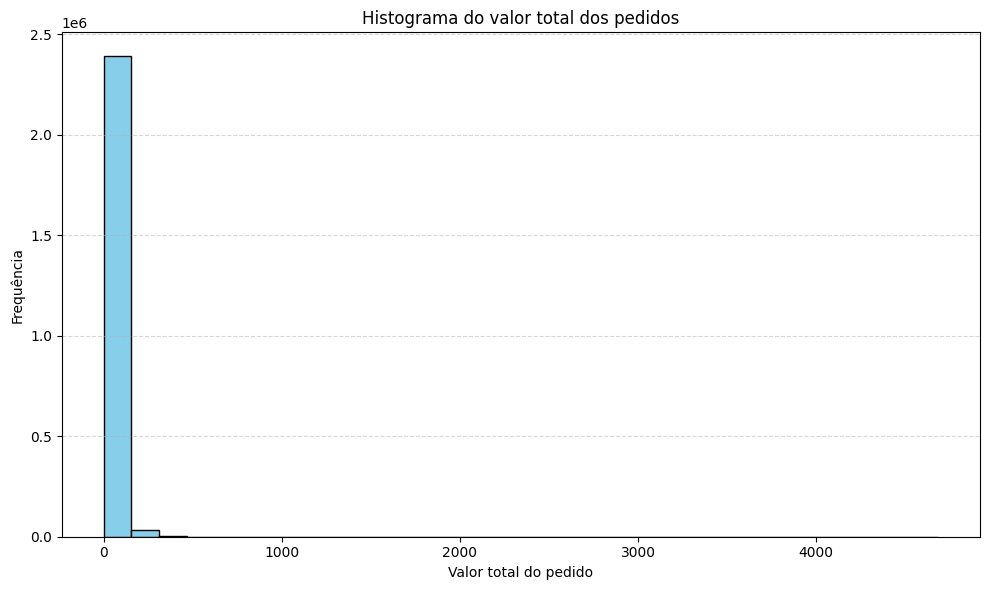

In [0]:
df_valores_pedidos = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .dropDuplicates(["order_id"])
    .select("is_target", "order_total_amount")
    .toPandas()
)


plt.figure(figsize=(10, 6))
plt.hist(df_valores_pedidos['order_total_amount'], bins=30, color='skyblue', edgecolor='black')
plt.title("Histograma do valor total dos pedidos")
plt.xlabel("Valor total do pedido")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

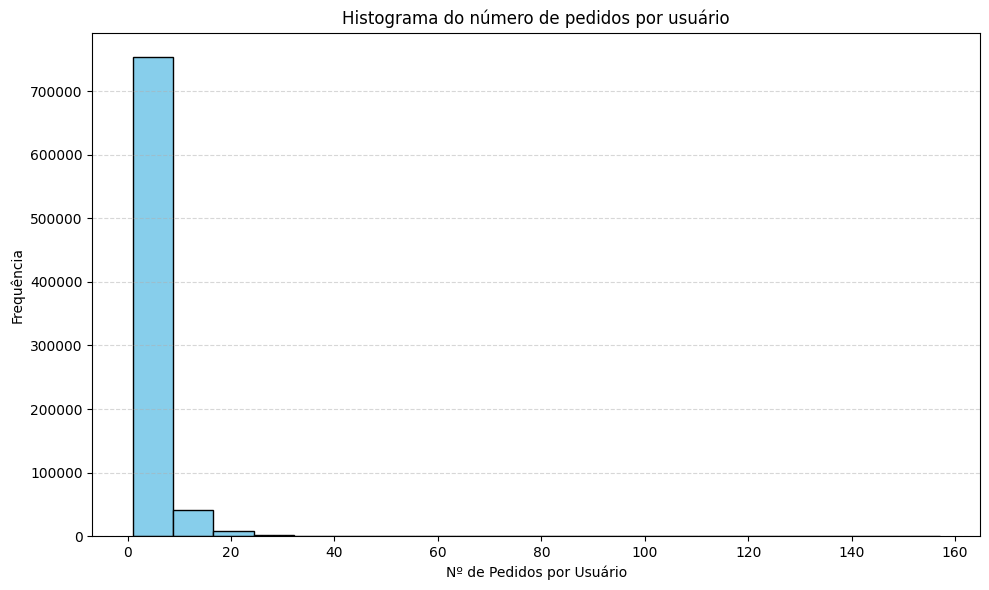

In [0]:
df_user_counts = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .dropDuplicates(["order_id"])
    .groupBy("customer_id_order", "is_target")
    .agg(F.count("order_id").alias("num_pedidos"))
).toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_user_counts['num_pedidos'], bins=20, color='skyblue', edgecolor='black')
plt.title("Histograma do número de pedidos por usuário")
plt.xlabel("Nº de Pedidos por Usuário")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Perceba que nos dois histogramas, a distribuição dos valores é muito assimétrica. Isso indica que não temos uma distribuição homogênea dos dados e provavelmente os dados não terão distribuição normal.

<Figure size 1400x600 with 0 Axes>

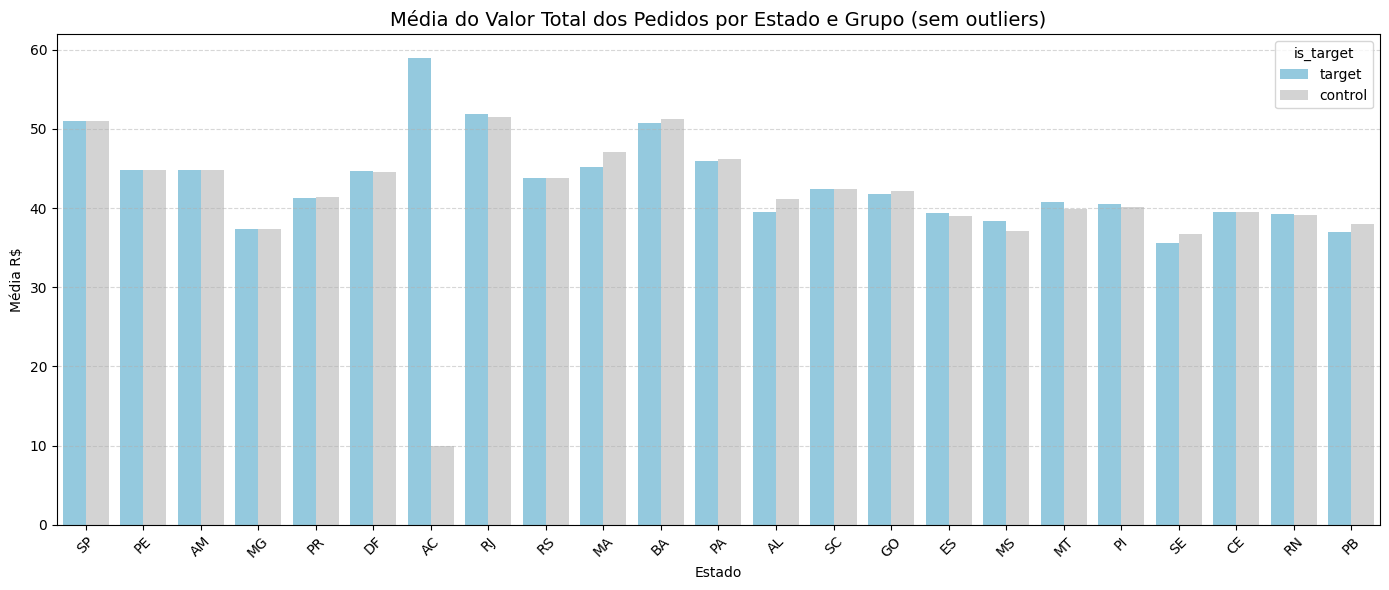

In [0]:
df_mapa = (
    spark.table("workspace.default.result_order")
    .filter(F.col("delivery_address_state").isNotNull())
    .filter(F.col("order_total_amount").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .dropDuplicates(["order_id"])  # garantir 1 linha por pedido
    .groupBy("is_target", "delivery_address_state")
    .agg(F.avg("order_total_amount").alias("media_order_total"))
    .toPandas()
)


# Ordenar os estados pela média
df_mapa_sorted = df_mapa.sort_values(by="media_order_total", ascending=False)

# Define a figura
plt.figure(figsize=(14, 6))

# Cria gráfico de barras com separação por grupo (control / target)
sns.barplot(
    data=df_mapa_sorted,
    x="delivery_address_state",
    y="media_order_total",
    hue="is_target",
    palette={"target": "skyblue", "control": "lightgray"}
)

plt.title("Média do Valor Total dos Pedidos por Estado e Grupo (sem outliers)", fontsize=14)
plt.xlabel("Estado")
plt.ylabel("Média R$")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

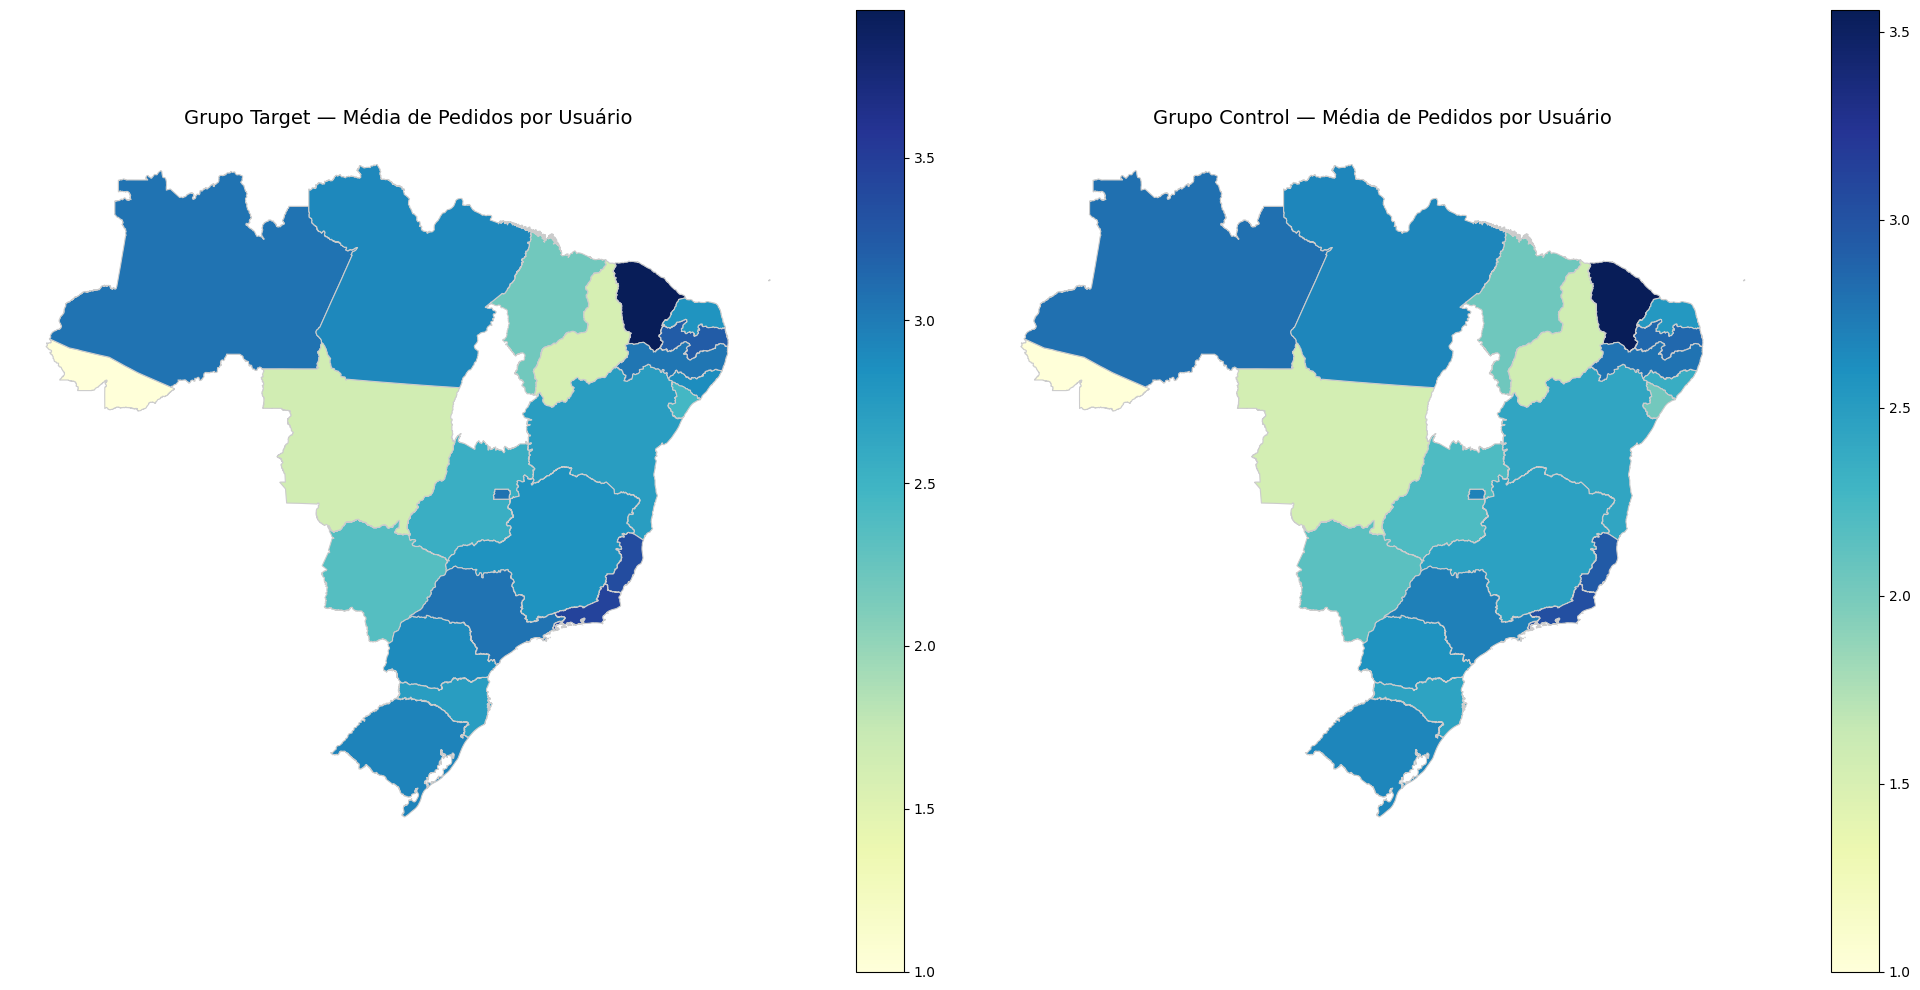

In [0]:
# Imports necessários
import geopandas as gpd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Caminho para o shapefile do Brasil (formato GeoJSON)
path_geojson = "/Volumes/workspace/default/brazil-states/brazil-states.geojson"

# Leitura do shapefile
estados_br = gpd.read_file(path_geojson)
estados_br["UF"] = estados_br["sigla"]

# ---------------------------------------
# Cálculo da MÉDIA DE PEDIDOS POR USUÁRIO
# ---------------------------------------
df_user_order_counts = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .filter(F.col("delivery_address_state").isNotNull())
    .filter(F.col("order_id").isNotNull())
    .dropDuplicates(["order_id"])  # garante 1 linha por pedido
    .groupBy("customer_id_order", "delivery_address_state", "is_target")
    .agg(F.count("order_id").alias("num_pedidos"))
    .toPandas()
)

# Agrupar por estado e grupo para obter a média de pedidos por usuário
df_mapa = (
    df_user_order_counts
    .groupby(["delivery_address_state", "is_target"])
    .agg(media_pedidos=("num_pedidos", "mean"))
    .reset_index()
)

# Garantir estado em UPPERCASE
df_mapa["delivery_address_state"] = df_mapa["delivery_address_state"].str.upper()

# Separar grupos
df_target = df_mapa[df_mapa["is_target"] == "target"]
df_control = df_mapa[df_mapa["is_target"] == "control"]

# Join com shapefile
mapa_target = estados_br.merge(df_target, how="left", left_on="UF", right_on="delivery_address_state")
mapa_control = estados_br.merge(df_control, how="left", left_on="UF", right_on="delivery_address_state")

# ---------------------------------------
# Plotagem dos dois mapas lado a lado
# ---------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Mapa TARGET
mapa_target.plot(
    column="media_pedidos",
    cmap="YlGnBu",
    linewidth=0.8,
    ax=axes[0],
    edgecolor="0.8",
    legend=True
)
axes[0].set_title("Grupo Target — Média de Pedidos por Usuário", fontsize=14)
axes[0].axis("off")

# Mapa CONTROL
mapa_control.plot(
    column="media_pedidos",
    cmap="YlGnBu",
    linewidth=0.8,
    ax=axes[1],
    edgecolor="0.8",
    legend=True
)
axes[1].set_title("Grupo Control — Média de Pedidos por Usuário", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()


Para analisar a eficiência do teste A/B, foi realizada a análise estatística de Wilcoxon-Mann-Whitney. Esta escolha foi feita por ser um método robusto e adequado para a natureza dos dados e dos objetivos do teste A/B, especialmente considerando as características observadas na distribuição dos dados (como a assimetria e a presença de outliers, conforme discutido anteriormente).

In [0]:
df_pedidos = (
    spark.table("workspace.default.result_order")
    .filter(F.col("order_id").isNotNull())
    .filter(F.col("order_total_amount").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)  # remove outliers
    .dropDuplicates(["order_id"])
    .select("customer_id_order", "is_target", "order_id", "order_total_amount")
    .toPandas()
)

# 2. Teste de normalidade (Shapiro-Wilk)
stat_shapiro, p_shapiro = shapiro(df_pedidos["order_total_amount"])
print(f"Shapiro-Wilk Test (sem outliers): W = {stat_shapiro:.5f}, p-value = {p_shapiro:.5f}")

Shapiro-Wilk Test (sem outliers): W = 0.69756, p-value = 0.00000


/databricks/python/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



O Teste de normalidade (Shapiro-Wilk) é usado para avaliar se uma variável segue uma distribuição normal.
Hispóteses do teste:

- Hipótese (H₀): A amostra vem de uma distribuição normal.
- Hipótese Alternativa (H₁): A amostra não vem de uma distribuição normal.


Como interpretar o p-valor:
- p > 0.05 → Não rejeitamos H₀ → A distribuição pode ser considerada normal
- p ≤ 0.05 → Rejeitamos H₀ → Os dados não seguem uma distribuição normal

De acordo com o resultado do teste, a amostra não vem de uma distribuição normal. Porttanto o teste não paramétrico de Wilcoxon-Mann-Whitney é o mais adequado.

In [0]:

# Primeiro vamos analisar se existe diferneça entre os dois grupos em relação ao valor total dos pedidos.

df_pedidos = (
    spark.table("workspace.default.result_order")
    .filter(F.col("order_id").isNotNull())
    .filter(F.col("order_total_amount").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)  # remove outliers
    .dropDuplicates(["order_id"])
    .select("customer_id_order", "is_target", "order_id", "order_total_amount")
    .toPandas()
)

grupo_control = df_pedidos[df_pedidos["is_target"] == "control"]["order_total_amount"]
grupo_target = df_pedidos[df_pedidos["is_target"] == "target"]["order_total_amount"]

# Teste de Wilcoxon-Mann-Whitney
stat_wilcoxon, p_wilcoxon = mannwhitneyu(grupo_control, grupo_target, alternative="two-sided")
print(f"Mann-Whitney Test: U = {stat_wilcoxon}, p-value = {p_wilcoxon:.5f}")

Mann-Whitney Test: U = 716301934323.5, p-value = 0.49706


Teste de Wilcoxon-Mann-Whitney é um teste não paramétrico usado para comparar duas amostras independentes, quando não podemos assumir normalidade.
Hispóteses do teste:

- Hipótese (H₀): Não há diferença significativa entre os dois grupos (teste e controle)
- Hipótese Alternativa (H₁): Há diferença significativa entre os dois grupos (teste e controle)


Como interpretar o p-valor:
- p > 0.05 → Não rejeitamos H₀
- p ≤ 0.05 → Rejeitamos H₀

De acordo com o resultado do teste, não há diferença significativa entre os dois grupos (teste e controle), relação ao valor total dos pedidos.

In [0]:
# Agora vamos analisar se existe diferneça entre os dois grupos em relação ao volume de pedidos por usuário. Queremos que o grupo teste tenha mais pedidos que o grupo controle.

df_volume = (
    spark.table("workspace.default.result_order")
    .filter(F.col("order_id").isNotNull())
    .filter(F.col("order_total_amount").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .groupBy("customer_id_order", "is_target")
    .agg(F.countDistinct("order_id").alias("qtd_pedidos"))
    .toPandas()
)

grupo_control = df_volume[df_volume["is_target"] == "control"]["qtd_pedidos"]
grupo_target = df_volume[df_volume["is_target"] == "target"]["qtd_pedidos"]

stat_wilcoxon, p_wilcoxon = mannwhitneyu(grupo_control, grupo_target, alternative="two-sided")
print(f"Mann-Whitney Test (volume de pedidos): U = {stat_wilcoxon}, p-value = {p_wilcoxon:.5f}")

Mann-Whitney Test (volume de pedidos): U = 72410958200.0, p-value = 0.00000



De acordo com o resultado do teste, HÁ DIFERENÇA SIGNIFICATIVA ENTRE OS GRUPOS (teste e controle), em relação ao volume de pedidos por usuário.


**a) Defina os indicadores relevantes para mensurar o sucesso da campanha e analise se ela teve impacto significativo dentro do
período avaliado.**

- Volume de Pedidos por Usuário
→ Indicador de recorrência. Mede o quanto os usuários retornaram para fazer novos pedidos após a campanha.

- Valor Total dos Pedidos
→ Reflete o impacto financeiro direto da campanha.

- Média e Mediana do Valor dos Pedidos
→ Indicadores de comportamento de consumo: se a campanha incentivou pedidos maiores ou apenas aumentou o volume.

- Desvio Padrão do Valor dos Pedidos
→ Mede a dispersão dos valores e indica se houve aumento da variabilidade após a campanha.


**b) Faça uma análise de viabilidade financeira dessa iniciativa como alavanca de crescimento, adotando as premissas que julgar necessárias (explicite as premissas adotadas).**

Com base nas análises realizadas, observamos dois pontos relevantes: o grupo teste apresentou um volume maior de vendas e um valor total de pedidos superior ao grupo controle. Embora os impactos iniciais sejam positivos, ainda não é possível concluir sobre a viabilidade financeira da campanha, pois é necessário considerar os custos envolvidos para uma avaliação completa.

**c) Recomende oportunidades de melhoria nessa ação e desenhe uma nova proposta de teste A/B para validar essas hipóteses.**
- Segmentação mais precisa dos usuários: atualmente, a campanha é aplicada de forma ampla. Criar segmentos baseados em comportamento de compra (ex: frequência, ticket médio, tipo de item comprado) pode aumentar a efetividade da ação.

- Diferenciação por perfil de consumo: usuários que consomem com menor frequência podem reagir melhor a incentivos maiores, enquanto usuários frequentes talvez necessitem apenas de um reforço de engajamento.


# Análise estatística - Parte II

In [0]:
# Standard Libraries
from datetime import date, timedelta

# Spark
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.functions import lower, get_json_object, when, coalesce, length
from pyspark.sql.utils import AnalysisException
from pyspark.sql import SparkSession

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import numpy as np
from plotnine import *
import geopandas as gpd
import plotly.express as px
from scipy.stats import shapiro, mannwhitneyu

from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from sklearn.cluster import KMeans
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

Para análise de segmentação, foram utilizados os seguintes parâmetros: 
- Frequência de compra: pedidos por usuário 
- Ticket médio: valor médio do total do pedido
- Localização geográfica do pedido
- Tipo de produto comprado
- Classificação do preço do restaurante

In [0]:
import pandas as pd
from pyspark.sql import functions as F
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from pyspark.sql import SparkSession

df = spark.table("workspace.default.result_order")


# Volume de pedidos por usuário
df_volume = (
    df.groupBy("customer_id_order")
    .agg(F.countDistinct("order_id").alias("volume_pedidos"))
)

# Ticket médio por usuário
df_ticket = (
    df.groupBy("customer_id_order")
    .agg(F.avg("order_total_amount").alias("ticket_medio"))
)

# Localização geográfica do pedido
df_estado = (
    df.select("customer_id_order", "delivery_address_state")
    .dropna(subset=["delivery_address_state"])
    .dropDuplicates(["customer_id_order"])
)

# Faixa de preço do restaurante
df_price_range = (
    df.select("customer_id_order", "price_range")
    .dropna(subset=["price_range"])
    .dropDuplicates(["customer_id_order"])
)

# União dos DataFrames
df_joined = (
    df_volume
    .join(df_ticket, on="customer_id_order", how="inner")
    .join(df_price_range, on="customer_id_order", how="inner")
    .join(df_estado, on="customer_id_order", how="inner")
)

df_joined = df_joined.filter(F.col("ticket_medio") <= 20000) # Retirando outiler

In [0]:
# Convertendo para Pandas
pdf = df_joined.toPandas()

# Convertendo de price_range para numérico (caso esteja como string)
pdf["price_range"] = pd.to_numeric(pdf["price_range"], errors="coerce")

# Definição das features
numerical_features = ["volume_pedidos", "ticket_medio"]
categorical_features = ["delivery_address_state", "price_range"]

# Pipeline de pré-processamento + KMeans
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

kmeans_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("kmeans", KMeans(n_clusters=4, random_state=42, n_init=10)) # Definição do número de grupos
])

# Treinamento
kmeans_pipeline.fit(pdf[numerical_features + categorical_features])

# Atribuição de cluster
pdf["cluster"] = kmeans_pipeline.named_steps["kmeans"].labels_

# Avaliação do modelo
print("Centros dos clusters (no espaço transformado):")
print(kmeans_pipeline.named_steps["kmeans"].cluster_centers_)

print("\nInertia (WSSSE):", kmeans_pipeline.named_steps["kmeans"].inertia_)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5e47cdd8a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

Centros dos clusters (no espaço transformado):
[[ 2.61443309e+00  6.47628830e-02  4.22516015e-03  1.24483213e-02
   2.17315585e-02  5.87130677e-02  3.47099178e-02  2.43060288e-02
   6.22416065e-03  1.24180334e-03  4.50835188e-02  2.65019006e-03
   1.36295489e-04  6.07272122e-03  1.66734814e-02  3.85413354e-02
   7.57197159e-05  4.24030409e-02  2.30854270e-01  8.42003241e-03
   2.78345676e-02  1.63403147e-02  1.33266700e-03  3.99981827e-01
   2.09471022e-01  2.06790544e-01  3.61198189e-01  1.56512653e-01
   6.60275923e-02]
 [-2.24658354e-01 -9.20117085e-03  5.49630696e-03  1.07444377e-02
   2.70717024e-02  4.07350571e-02  3.54095136e-02  2.18759392e-02
   1.15049043e-02  3.08284988e-03  6.34283841e-02  5.40750995e-03
   9.53998597e-04  5.33009718e-03  1.64843672e-02  3.08262220e-02
   0.00000000e+00  4.91935410e-02  2.01817379e-01  9.32596242e-03
   3.13294050e-02  2.15526270e-02  3.03958980e-03  4.05390206e-01
   3.18448830e-01  3.29227421e-01  0.00000000e+00  2.66527627e-01
   8.57961

In [0]:
# 1Conversão de volta para Spark
df_result = spark.createDataFrame(pdf[["customer_id_order", "delivery_address_state", "price_range", 
                                       "volume_pedidos", "ticket_medio", "cluster"]])


# Salvando tabela
df_result.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable("workspace.default.customer_clusters_pandas_sklearn")


# Leitura da tabela
df_agrup = spark.table("workspace.default.customer_clusters_pandas_sklearn")
display(df_agrup.limit(10))

customer_id_order delivery_address_state price_range volume_pedidos ticket_medio cluster 7d0c7032c983fcfeaff32e198f2b7b6fdcd000cbcfe9f0d1636f2a63ca168b0e CE 2 14 70.89026578073087 0 35b77315cfa54dcb5aec430f24c2d965dc8df204c23bf06f51a63c7d5a45e614 SP 3 4 34.6 2 5eba007f5cc4ca46d546f75a9cd9451498fa7be49cc2a16db92a41a4612eec21 SP 4 1 57.0 1 bf878324aba8856679f2520eab47635e60a167805508bb6c0825775ca0460de8 SP 4 6 84.69058823529411 1 32a30d7da2541dcb72f14c07d774bb9f5ad45232c3e8cc9eff5527bdad22530a SP 2 8 41.76217391304348 0 0f7508173c5a0e1daf30c8e4ddb0657ced27f5d4ffde55369491ef05a772ab50 RJ 2 3 56.55555555555556 1 0fc7c46c1a485dab49c18b5a23fbfea7c1c9d5fbc63aba807f295c5d77b4e162 RS 4 1 53.9 1 943fd26228913e0282a66ccc238a741bc7651aa37af57d940347f63c9495fbb7 SP 1 12 31.281612903225813 0 2cfe3a8a643624fd683296671e3d34b339d8d4d2ed8dab44985772cea2f0029f MG 1 3 35.885714285714286 1 384062728ec1434d09b71db63593b13f223b44a720cc34ae22e15e7050cc306b SP 3 7 39.588235294117645 2

**Como foram definidos o número de grupos (k)?**

Inicialmente foram escolhidos 3 grupos com base em conhecimento de negócio e uma análise preliminar da distribuição das variáveis. Em seguida, validei essa escolha utilizando o método do cotovelo (Elbow Method), que analisa a variação da Inertia (WSSSE) em diferentes valores de k e também utilizando a análise gráfica abaixo. A partir do ponto onde a redução da inércia se estabiliza, podemos considerar um número ótimo de clusters, e no nosso caso, k=4 mostrou-se adequado.

**Qual abordagem utilizada?**

Foi utilizado o algoritmo de KMeans com dados previamente tratados: variáveis numéricas foram padronizadas e variáveis categóricas, como localização e faixa de preço, foram transformadas em dummies. Todo o pipeline foi estruturado via Scikit-learn para garantir o pré-processamento correto e evitar viés no agrupamento.

O K-Means é um dos algoritmos de clusterização mais populares e amplamente utilizados. Em termos simples, ele agrupa pontos de dados em um número pré-definido de "clusters" (grupos), de forma que os pontos dentro de um mesmo cluster sejam o mais semelhantes possível entre si, e diferentes dos pontos em outros clusters.

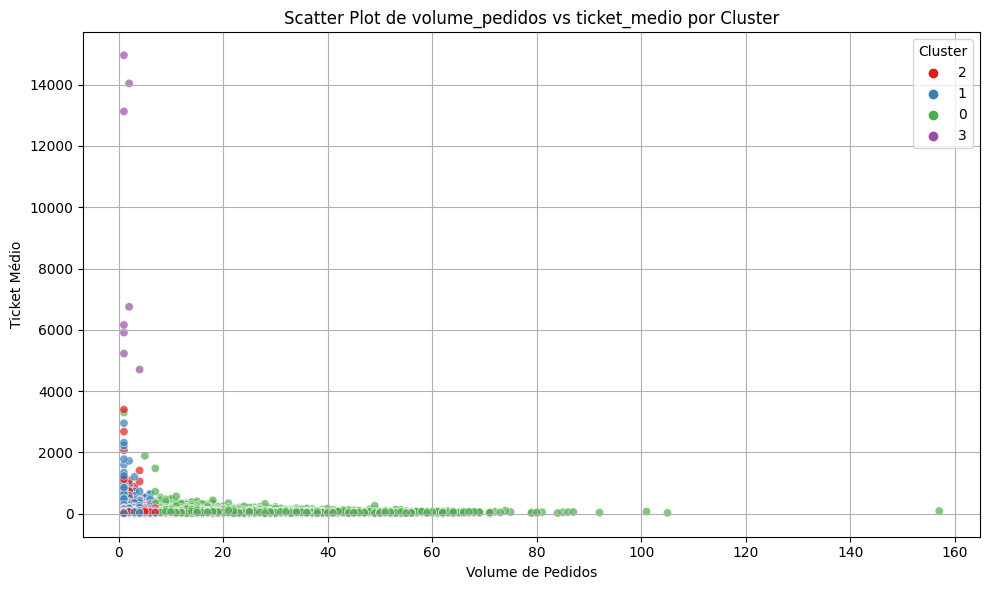

In [0]:
# 1. Carregar a base clusterizada salva no Delta Lake
df_clusters = spark.table("workspace.default.customer_clusters_pandas_sklearn").toPandas()

# 2. Garantir que o cluster seja interpretado como categoria (como em R)
df_clusters["cluster"] = df_clusters["cluster"].astype(str)

# 3. Criar o scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clusters,
    x="volume_pedidos",
    y="ticket_medio",
    hue="cluster",
    palette="Set1",
    alpha=0.7
)
plt.title("Scatter Plot de volume_pedidos vs ticket_medio por Cluster")
plt.xlabel("Volume de Pedidos")
plt.ylabel("Ticket Médio")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

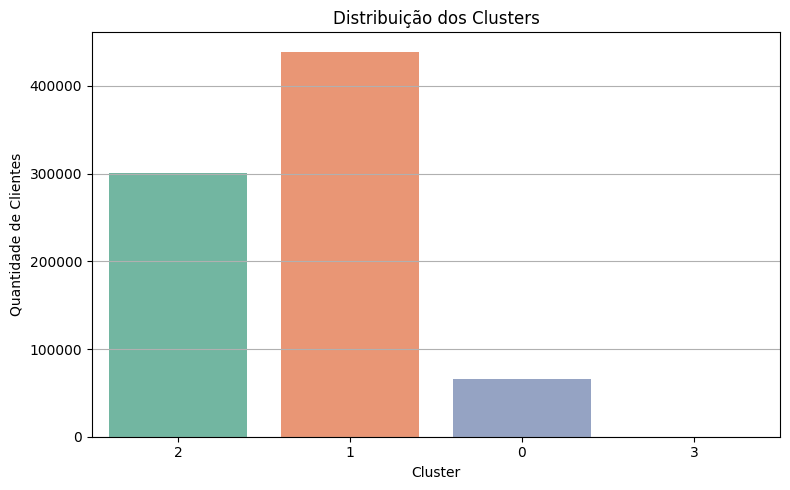

In [0]:
# Garantir que o cluster esteja como string para fins de visualização
df_clusters["cluster"] = df_clusters["cluster"].astype(str)

# Criar o bar plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clusters, x="cluster", palette="Set2")
plt.title("Distribuição dos Clusters")
plt.xlabel("Cluster")
plt.ylabel("Quantidade de Clientes")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [0]:
df_clusters = spark.table("workspace.default.customer_clusters_pandas_sklearn")
df_result_order = spark.table("workspace.default.result_order")

# Faz o join para adicionar a coluna 'cluster' na base original
df_result_com_cluster = (
    df_result_order
    .join(df_clusters.select("customer_id_order", "cluster"), on="customer_id_order", how="left")
)

# Exibe a nova base com todas as colunas + cluster
display(df_result_com_cluster.limit(10))

df_result_com_cluster.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable("workspace.default.result_order_cluster")

customer_id_order cpf customer_name delivery_address_city delivery_address_country delivery_address_district delivery_address_external_id delivery_address_latitude delivery_address_longitude delivery_address_state delivery_address_zip_code merchant_id merchant_latitude merchant_longitude merchant_timezone order_created_at order_id order_scheduled order_total_amount origin_platform item_name item_addition_value item_addition_currency item_discount_value item_discount_currency item_quantity item_sequence item_unit_price_value item_unit_price_currency item_external_id item_total_value_value item_total_value_currency item_customer_note garnish_item_name garnish_item_addition_value garnish_item_addition_currency garnish_item_discount_value garnish_item_discount_currency garnish_item_quantity garnish_item_sequence garnish_item_unit_price_value garnish_item_unit_price_currency garnish_item_category_id garnish_item_external_id garnish_item_total_value_value garnish_item_total_value_currency garnish_item_category_name garnish_item_integration_id customer_id_teste_ab is_target customer_id language consumer_created_at active customer_phone_area customer_phone_number restaurant_created_at enabled price_range average_ticket takeout_time delivery_time minimum_order_value merchant_zip_code merchant_city merchant_state merchant_country cluster 35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952 24917797900 ULISSES JUIZ DE FORA BR CASCATINHA 6760884 -43.36 -21.78 MG 36033 dd3915c8589797c626a80b506abf4ad85f7ff7fb3a2a61c865da0c3c834ac0bd -43.36 -21.78 America/Sao_Paulo 2019-01-06T23:07:53.000Z 1b3f0287d7cc080e3060df78054ba251745a48e2dd6c25c296bd61957a4b6040 false 90.9 DESKTOP 403 Mariano Procópio 0 BRL 0 BRL 1.0 1 0 BRL ee0f88c318af4612998392a0ead7b10c 0 BRL null AO PONTO 0 BRL 0 BRL 1.0 2 0 BRL ASC2 82d8b31676374f889675a55ea1504796 0 BRL PONTO DA CARNE null 35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952 target 35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952 pt-br 2018-01-03T21:51:47.815Z true 2 210686545 2017-01-20T13:14:31.214Z false 5 100.0 0 50 0.0 36035 JUIZ DE FORA MG BR 1 35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952 24917797900 ULISSES JUIZ DE FORA BR CASCATINHA 6760884 -43.36 -21.78 MG 36033 dd3915c8589797c626a80b506abf4ad85f7ff7fb3a2a61c865da0c3c834ac0bd -43.36 -21.78 America/Sao_Paulo 2019-01-06T23:07:53.000Z 1b3f0287d7cc080e3060df78054ba251745a48e2dd6c25c296bd61957a4b6040 false 90.9 DESKTOP 403 Mariano Procópio 0 BRL 0 BRL 1.0 1 0 BRL ee0f88c318af4612998392a0ead7b10c 0 BRL null Inteira 0 BRL 0 BRL 1.0 3 8290 BRL AXUI 2dc5b08c22954891a931d4f3c6b63c73 8290 BRL Tamanho null 35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952 target 35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952 pt-br 2018-01-03T21:51:47.815Z true 2 210686545 2017-01-20T13:14:31.214Z false 5 100.0 0 50 0.0 36035 JUIZ DE FORA MG BR 1 35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952 24917797900 ULISSES JUIZ DE FORA BR CASCATINHA 6760884 -43.36 -21.78 MG 36033 dd3915c8589797c626a80b506abf4ad85f7ff7fb3a2a61c865da0c3c834ac0bd -43.36 -21.78 America/Sao_Paulo 2019-01-06T23:07:53.000Z 1b3f0287d7cc080e3060df78054ba251745a48e2dd6c25c296bd61957a4b6040 false 90.9 DESKTOP Refrigerantes 2LT 0 BRL 0 BRL 1.0 4 0 BRL 21240296966a461989f5027060697375 0 BRL null Coca-cola 0 BRL 0 BRL 1.0 5 800 BRL AN5P 87b411e3029b4c319565e01663856586 800 BRL Escolha null 35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952 target 35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952 pt-br 2018-01-03T21:51:47.815Z true 2 210686545 2017-01-20T13:14:31.214Z false 5 100.0 0 50 0.0 36035 JUIZ DE FORA MG BR 1 23033ace6c281bc27e3525f16fa0339c5e7a988e15912e647cebe00207749785 40103289230 MARIA RIO DE JANEIRO BR JARDIM GUANABARA 2190167 -43.21 -22.82 RJ 21940 fa140fe3df83f225f95a07243a0b7134a3a119756a428c377a847e0b38e8c853 -43.21 -22.82 America/Sao_Paulo 2018-12-29T00:07:25.000Z f

In [0]:
df_orders = spark.table("workspace.default.result_order_cluster")

# Calculando métricas por cliente
df_metrics = (
    df_orders.groupBy("customer_id_order", "cluster", "delivery_address_state")
    .agg(
        F.countDistinct("order_id").alias("volume_pedidos"),
        F.avg("order_total_amount").alias("media_valor_pedido"),
        F.avg("price_range").alias("price_range_medio")
    )
)

# Agregando por cluster para obter médias
df_summary = (
    df_metrics.groupBy("cluster")
    .agg(
        F.countDistinct("customer_id_order").alias("usuarios_distintos"),
        F.round(F.avg("volume_pedidos"), 2).alias("volume_pedidos_medio"),
        F.round(F.avg("media_valor_pedido"), 2).alias("media_valor_pedido"),
        F.round(F.avg("price_range_medio"), 2).alias("price_range_medio")
    )
)

# Percentual por estado dentro de cada cluster
df_estado = (
    df_metrics.groupBy("cluster", "delivery_address_state")
    .agg(F.countDistinct("customer_id_order").alias("qtd_usuarios_estado"))
)

window_cluster = Window.partitionBy("cluster")

df_percentual_estado = (
    df_estado
    .withColumn("total_cluster", F.sum("qtd_usuarios_estado").over(window_cluster))
    .withColumn("percentual", F.round(F.col("qtd_usuarios_estado") / F.col("total_cluster") * 100, 2))
    .orderBy("cluster", F.desc("percentual"))
)


display(df_summary.where(F.col("cluster").isNotNull()))
display(df_percentual_estado.where(F.col("cluster").isNotNull()))

cluster usuarios_distintos volume_pedidos_medio media_valor_pedido price_range_medio 1 439204 2.14 49.04 2.52 0 66033 12.07 52.71 2.66 2 301220 2.06 49.16 2.94 3 8 1.44 8740.92 3.67

cluster delivery_address_state qtd_usuarios_estado total_cluster percentual 0 SP 27360 70047 39.06 0 RJ 16116 70047 23.01 0 CE 4095 70047 5.85 0 MG 3192 70047 4.56 0 PR 2994 70047 4.27 0 PE 2799 70047 4.0 0 DF 2450 70047 3.5 0 RS 1946 70047 2.78 0 ES 1712 70047 2.44 0 BA 1647 70047 2.35 0 SC 1266 70047 1.81 0 PB 1206 70047 1.72 0 AM 875 70047 1.25 0 RN 653 70047 0.93 0 GO 463 70047 0.66 0 PA 446 70047 0.64 0 AL 358 70047 0.51 0 MS 195 70047 0.28 0 SE 123 70047 0.18 0 MA 113 70047 0.16 0 MT 21 70047 0.03 0 PI 16 70047 0.02 0 AC 1 70047 0.0 1 SP 179727 445632 40.33 1 RJ 89921 445632 20.18 1 MG 28274 445632 6.34 1 PR 21903 445632 4.92 1 CE 18188 445632 4.08 1 DF 15845 445632 3.56 1 RS 13962 445632 3.13 1 PE 13894 445632 3.12 1 BA 12198 445632 2.74 1 ES 9795 445632 2.2 1 SC 9745 445632 2.19 1 PB 7384 445632 1.66 1 GO 5144 445632 1.15 1 AM 4802 445632 1.08 1 RN 4258 445632 0.96 1 AL 2512 445632 0.56 1 PA 2428 445632 0.54 1 MS 2415 445632 0.54 1 SE 1378 445632 0.31 1 MA 1401 445632 0.31 1 MT 446 445632 0.1 1 PI 11 445632 0.0 1 AC 1 445632 0.0 2 SP 140420 305894 45.9 2 RJ 48398 305894 15.82 2 PE 15875 305894 5.19 2 PR 15175 305894 4.96 2 MG 14965 305894 4.89 2 DF 11117 305894 3.63 2 BA 10286 305894 3.36 2 RS 9174 305894 3.0 2 CE 7965 305894 2.6 2 SC 6254 305894 2.04 2 ES 5782 305894 1.89 2 AM 4476 305894 1.46 2 PB 3929 305894 1.28 2 RN 3140 305894 1.03 2 PA 2547 305894 0.83 2 GO 1996 305894 0.65 2 AL 1472 305894 0.48 2 MS 1325 305894 0.43 2 SE 624 305894 0.2 2 MT 449 305894 0.15 2 MA 351 305894 0.11 2 PI 174 305894 0.06 3 SP 2 9 22.22 3 RJ 2 9 22.22 3 MT 1 9 11.11 3 ES 1 9 11.11 3 RS 1 9 11.11 3 CE 1 9 11.11 3 MG 1 9 11.11

**Abaixo estão as respostas do item 2, letras A e B.**

🟢 **Cluster 0 – Clientes Engajados**

- Usuários distintos: 66.033
- Volume médio de pedidos: 12,07
- Ticket médio: R$ 52,71
- Classificação de preço do restaurante (média): 2,66
- Distribuição geográfica: SP (39%) e RJ (23%) concentram mais de 60% dos usuários desse grupo. Presença considerável no Nordeste (ex: CE, PE) e MG.

Interpretação:
Esse é um grupo de clientes com alto engajamento (volume de pedidos significativamente superior aos demais) e ticket médio ligeiramente acima da média. Eles costumam consumir de restaurantes de preço intermediário para alto. Com forte presença em grandes centros urbanos, especialmente SP e RJ.

Perfil: Cliente fiel, potencial promotor da marca, com poder de compra moderado. Pode ser ideal para programas de fidelidade ou campanhas de cashback.

--------------------------


🔵 **Cluster 1 – Cliente Ocasional / Médio**

- Usuários distintos: 439.204
- Volume médio de pedidos: 2,14
- Ticket médio: R$ 49,04
- Classificação de preço do restaurante (média): 2,52
- Distribuição geográfica: Grande presença em SP, RJ e MG, mas mais disperso que o Cluster 0.

Interpretação:
Maior grupo da base. São clientes com baixo volume de pedidos, ticket próximo do valor médio e preferência por estabelecimentos de preço intermediário.

Perfil: Clientes ocasionais ou que usam o serviço em datas específicas. Pode ser interessante aplicar campanhas de reativação ou ofertas personalizadas para aumentar o LTV.

--------------------------

🔴 **Cluster 2 – Cliente Econômico**

- Usuários distintos: 301.220
- Volume médio de pedidos: 2,06
- Ticket médio: R$ 49,16
- Classificação de preço do restaurante (média): 2,94
- Também fortemente representado em SP e RJ, mas com leve viés para restaurantes mais caros.

Interpretação:
Também de baixa frequência, como o cluster 1, mas com preferência clara por restaurantes mais caros (faixa de preço média mais alta). Isso pode indicar usuários de ticket elevado pontual, como compras para grupos/família ou pedidos especiais.

Perfil: Clientes com poder aquisitivo maior, mas uso pouco frequente. Pode valer a pena explorar ofertas premium, parcerias com restaurantes de alta qualidade ou programas de indicações.

--------------------------

⚫ **Cluster 3 – Outliers / Clientes Corporativos**

- Usuários distintos: 8
- Volume médio de pedidos: 1,44
- Ticket médio: R$ 8.740,92
- Classificação de preço do restaurante (média): 3,67
- Distribuição geográfica: Não representativa

Interpretação:
Grupo muito pequeno e atípico. O valor médio do pedido é extremamente alto e a faixa de preço é elevada também. Isso sugere clientes corporativos ou erro de cadastro/registro.
Perfil: Provável outlier. Pode ser interessante remover da análise geral ou criar um segmento separado para análise especializada (B2B, eventos, etc.).


Resumindo, temos a seguinte proposta de teste com os grupos:
- Focar ações de fidelização e retenção no Cluster 0.
- Criar estratégias de reengajamento para Clusters 1 e 2, com diferenciação no tipo de benefício (econômico vs. premium).


In [0]:
df_orders = spark.table("workspace.default.result_order_cluster")

# Calculando métricas por cliente
df_metrics = (
    df_orders.groupBy("customer_id_order", "cluster", "delivery_address_state", "is_target")
    .agg(
        F.countDistinct("order_id").alias("volume_pedidos"),
        F.avg("order_total_amount").alias("media_valor_pedido"),
        F.avg("price_range").alias("price_range_medio")
    )
)

# Agregndo  por cluster e is_target para obter médias
df_summary = (
    df_metrics.groupBy("cluster", "is_target")
    .agg(
        F.countDistinct("customer_id_order").alias("usuarios_distintos"),
        F.round(F.avg("volume_pedidos"), 2).alias("volume_pedidos_medio"),
        F.round(F.avg("media_valor_pedido"), 2).alias("media_valor_pedido"),
        F.round(F.avg("price_range_medio"), 2).alias("price_range_medio")
    )
    .orderBy("cluster", "is_target")
)

# Percentual por estado dentro de cada cluster e is_target
df_estado = (
    df_metrics.groupBy("cluster", "is_target", "delivery_address_state")
    .agg(F.countDistinct("customer_id_order").alias("qtd_usuarios_estado"))
)

window_cluster_target = Window.partitionBy("cluster", "is_target")

df_percentual_estado = (
    df_estado
    .withColumn("total_cluster", F.sum("qtd_usuarios_estado").over(window_cluster_target))
    .withColumn("percentual", F.round(F.col("qtd_usuarios_estado") / F.col("total_cluster") * 100, 2))
    .orderBy("cluster", "is_target", F.desc("percentual"))
)


display(df_summary.where(F.col("cluster").isNotNull()))
display(df_percentual_estado.where(F.col("cluster").isNotNull()))


cluster is_target usuarios_distintos volume_pedidos_medio media_valor_pedido price_range_medio 0 control 26476 12.05 52.9 2.65 0 target 39557 12.09 52.59 2.66 1 control 197858 2.01 48.79 2.51 1 target 241346 2.24 49.24 2.52 2 control 136203 1.94 49.05 2.95 2 target 165017 2.15 49.25 2.94 3 control 4 1.5 10020.41 3.75 3 target 4 1.4 7717.33 3.6

cluster is_target delivery_address_state qtd_usuarios_estado total_cluster percentual 0 control SP 10944 28141 38.89 0 control RJ 6466 28141 22.98 0 control CE 1647 28141 5.85 0 control MG 1266 28141 4.5 0 control PR 1228 28141 4.36 0 control PE 1184 28141 4.21 0 control DF 953 28141 3.39 0 control RS 791 28141 2.81 0 control ES 677 28141 2.41 0 control BA 678 28141 2.41 0 control SC 515 28141 1.83 0 control PB 475 28141 1.69 0 control AM 365 28141 1.3 0 control RN 264 28141 0.94 0 control PA 187 28141 0.66 0 control GO 179 28141 0.64 0 control AL 130 28141 0.46 0 control MS 86 28141 0.31 0 control MA 49 28141 0.17 0 control SE 44 28141 0.16 0 control MT 10 28141 0.04 0 control PI 3 28141 0.01 0 target SP 16416 41906 39.17 0 target RJ 9650 41906 23.03 0 target CE 2448 41906 5.84 0 target MG 1926 41906 4.6 0 target PR 1766 41906 4.21 0 target PE 1615 41906 3.85 0 target DF 1497 41906 3.57 0 target RS 1155 41906 2.76 0 target ES 1035 41906 2.47 0 target BA 969 41906 2.31 0 target SC 751 41906 1.79 0 target PB 731 41906 1.74 0 target AM 510 41906 1.22 0 target RN 389 41906 0.93 0 target GO 284 41906 0.68 0 target PA 259 41906 0.62 0 target AL 228 41906 0.54 0 target MS 109 41906 0.26 0 target SE 79 41906 0.19 0 target MA 64 41906 0.15 0 target PI 13 41906 0.03 0 target MT 11 41906 0.03 0 target AC 1 41906 0.0 1 control SP 80786 200441 40.3 1 control RJ 40384 200441 20.15 1 control MG 12789 200441 6.38 1 control PR 9918 200441 4.95 1 control CE 8066 200441 4.02 1 control DF 7091 200441 3.54 1 control RS 6321 200441 3.15 1 control PE 6273 200441 3.13 1 control BA 5530 200441 2.76 1 control SC 4438 200441 2.21 1 control ES 4299 200441 2.14 1 control PB 3377 200441 1.68 1 control GO 2282 200441 1.14 1 control AM 2106 200441 1.05 1 control RN 1944 200441 0.97 1 control AL 1163 200441 0.58 1 control MS 1094 200441 0.55 1 control PA 1080 200441 0.54 1 control MA 658 200441 0.33 1 control SE 630 200441 0.31 1 control MT 207 200441 0.1 1 control AC 1 200441 0.0 1 control PI 4 200441 0.0 1 target SP 98941 245191 40.35 1 target RJ 49537 245191 20.2 1 target MG 15485 245191 6.32 1 target PR 11985 245191 4.89 1 target CE 10122 245191 4.13 1 target DF 8754 245191 3.57 1 target RS 7641 245191 3.12 1 target PE 7621 245191 3.11 1 target BA 6668 245191 2.72 1 target ES 5496 245191 2.24 1 target SC 5307 245191 2.16 1 target PB 4007 245191 1.63 1 target GO 2862 245191 1.17 1 target AM 2696 245191 1.1 1 target RN 2314 245191 0.94 1 target PA 1348 245191 0.55 1 target AL 1349 245191 0.55 1 target MS 1321 245191 0.54 1 target SE 748 245191 0.31 1 target MA 743 245191 0.3 1 target MT 239 245191 0.1 1 target PI 7 245191 0.0 2 control SP 63580 138116 46.03 2 control RJ 21836 138116 15.81 2 control PE 7030 138116 5.09 2 control PR 6834 138116 4.95 2 control MG 6768 138116 4.9 2 control DF 5076 138116 3.68 2 control BA 4636 138116 3.36 2 control RS 4061 138116 2.94 2 control CE 3568 138116 2.58 2 control SC 2895 138116 2.1 2 control ES 2601 138116 1.88 2 control AM 2055 138116 1.49 2 control PB 1758 138116 1.27 2 control RN 1385 138116 1.0 2 control PA 1109 138116 0.8 2 control GO 906 138116 0.66 2 control AL 678 138116 0.49 2 control MS 594 138116 0.43 2 control SE 290 138116 0.21 2 control MT 214 138116 0.15 2 control MA 164 138116 0.12 2 control PI 78 138116 0.06 2 target SP 76840 167778 45.8 2 target RJ 26562 167778 15.83 2 target PE 8845 167778 5.27 2 target PR 8341 167778 4.97 2 target MG 8197 167778 4.89 2 target DF 6041 167778 3.6 2 target BA 5650 167778 3.37 2 target RS 5113 167778 3.05 2 target CE 4397 167778 2.62 2 target SC 3359 167778 2.0 2 target ES 3181 167778 1.9 2 target AM 2421 167778 1.44 2 target PB 2171 167778 1.29 2 target RN 1755 167778 1.05 2 target PA 1438 167778 0.86 2 target GO 1090 167778 0.65 2 target AL 794 167778 0.47 2 target MS 731 167778 0.44 2 target SE 334 167778 0.2 2 target MT 235 167778 0.14 2 target MA 187 167778 0.11 2 target PI 96 167778 0.06 3 control ES 1 4 25.0 3 control RS 1 4 25.0 3 control MG 1 4 25.0 3 contro

**Abaixo estão as respostas do item 2, letra C.**

🟢 **Cluster 0 – Usuários de alta frequência e ticket médio alto**
- Comportamento entre controle e target é praticamente idêntico.
- Controle: 12.05 pedidos | R$ 52.9 | Price range: 2.65
- Target: 12.09 pedidos | R$ 52.59 | Price range: 2.66

Interpretação: O cupom não teve efeito prático aqui. Esses usuários já compram muito e com frequência, mesmo sem incentivo.

Possível ação: Cupom pode ser desnecessário para este grupo. Avaliar estratégias mais sofisticadas, como programas de fidelidade.

-----------------------------

🔵 **Cluster 1 – Maior grupo, usuários de baixa frequência**
- Controle: 2.01 pedidos | R$ 48.79
- Target: 2.24 pedidos | R$ 49.24
- Aumento visível no volume de pedidos (coerente com o Wilcoxon).
- Ticket médio estável.

Interpretação: O cupom funcionou parcialmente aqui — aumentou o volume de pedidos, mas não o valor gasto.

Possível ação: Grupo mais sensível a incentivo → foco da campanha de cupom. Incentivar recorrência e ticket maior.

-----------------------------

🔴 **Cluster 2 – Similar ao cluster 1, mas com restaurantes mais caros**
- Controle: 1.94 pedidos | R$ 49.05 | Price range: 2.95
- Target: 2.15 pedidos | R$ 49.25 | Price range: 2.94
- Comportamento parecido com o cluster 1.
- Efeito do cupom também presente, mas levemente inferior.

Interpretação: Usuários que compram pouco e usam restaurantes de ticket mais alto.

Possível ação: Estratégia de cupom pode continuar, talvez com foco em promoções em restaurantes premium.

-----------------------------

⚫ **Cluster 3 – Outliers com ticket médio absurdamente alto**

4 usuários por grupo. Ticket médio > R$ 7.000. Não confiável para análise estatística. Ignorar ou tratar como outlier.

**Recomendação: Otimizar a distribuição dos cupons com base em segmentação de usuários**

A análise mostrou que o cupom não aumentou o ticket médio, mas gerou aumento significativo no volume de pedidos — especialmente entre usuários dos clusters 1 e 2, que representam mais de 85% da base total.

Resumo por cluster (segmento):
- 0:	Perfil: alta frequência | Ticket alto	| Efeito docupom: nenhum |	Remover cupons e usar fidelidade
- 1: 	Perfil: baixa frequência | Ticket médio	|	Efeito docupom: aumento de pedidos  |	Manter cupons, com foco em recorrência
- 2:	Perfil: baixa frequência | Restaurantes caros	|	Efeito docupom: aumento de pedidos | Manter cupons, com foco em valor


**Impacto financeiro:**

Eficiência de campanha: ao focar onde o cupom funciona, melhora-se o ROI. Além disso, essa economia pode ser reinvestida para ampliar o incentivo nos clusters com maior resposta (1 e 2), gerando mais receita.

**Melhorias no processo/teste:**

- Redefinir os critérios de distribuição dos cupons, focando nos clusters 1 e 2.
- Testar novos valores de cupom por cluster. Exemplo: R$ 3 para cluster 1, e R$ 7 para cluster 2.
- Realizar novo teste A/B segmentado, com foco em validar o desempenho por cluster.